## First Generation : Price Sequences

미시 구조 모델의 1세대는 illiquidity의 대용 척도로서 매매 호가 스프레드와 변동성을 추정하는 것에 주안점을 뒀다. 이들은 제한된 데이터를 이용해 거래 프로세스에 전략적 또는 순차적 구조를 두지 않고 추정했다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_parquet('../../Data/AAPL_tick.parquet')

### The Tick Rule

이중 경매 호가창에서 호가는 증권을 팔기 위한 다양한 가격 수준에서 증권을 팔거나, 다양한 가격 수준에서 증권을 사기 위해 제시된다. 매도 호가는 항상 매수 호가를 초과한다. 그렇지 않다면 즉시 매치가 이뤄졌을 것이기 때문이다. 거래는 매수자가 매도 호가를 매치하거나, 매도자가 매수 호가를 매치하는 경우에 일어난다. 모든 거래에는 매수자와 매도자가 있지만 오직 한쪽만이 거래를 일으킨다.

틱 규칙이란 거래에 있어서 공격적 거래자의 방향(aggressor side)을 결정하기 위한 알고리즘이다. 다음 논리에 따라서 매수가 주도한 거래는 1, 매도가 주도한 거래가 -1로 labeling을 한다

$$b_t = \begin{cases}
1, ~~ & \mbox{if } \Delta p_t > 0\\
-1, ~~ & \mbox{if } \Delta p_t < 0\\
b_{t-1}, ~~ & \mbox{if } \Delta p_t = 0
\end{cases}$$

여기서 $p_t$는 $t=1,\cdots, T$로 인덱스된 거래 가격이고, $b_0$은 임의로 1로 설정된다. 여러 연구를 통해 틱 규칙은 상대적으로 단순함에도 불구하고 높은 분류 정확도를 가진다. $\{b_t\}$ 계열의 변환은 정보성 특성을 만들어낼 수 있다. 이런 변환에는 다음과 같은 것들이 있다.

1. 미래 기대값 $E_t[b_{t+1}]$에 대한 Kalman Filter
2. 이런 예측에 대한 구조적 변화
3. $\{b_t\}$ sequence의 Entropy
4. $\{b_t\}$ 런에 대한 Wald-Wolfowitz 테스트로부터의 t값
5. 누적 $\{b_t\}$계열 $\sum_{t=1}^t b_t$의 fractionallly diffrentiated features

In [2]:
from FinancialMachineLearning.features.microstructure import *

tick_side = tick_rule(data['Price'])

In [3]:
tick_side.head()

2023-04-03 09:30:00    1.0
2023-04-03 09:30:00   -1.0
2023-04-03 09:30:00    1.0
2023-04-03 09:30:00   -1.0
2023-04-03 09:30:00   -1.0
dtype: float64

In [4]:
data['Side'] = tick_side

### The Roll Model of Trade Prices

Roll(1984)은 증권이 거래되는 effective bid-ask spread를 설명하는 첫 번째 모델 중 하나다. 증권의 liquidity를 계량화하려는 초창기 시도로 알려져 있으며, 시장미시구조(Market Microstructure) 분야를 개척한 모형 중 가장 유명한 모델이다.

#### Random walk model of security prices

시간 $t$에서 거래되는 가격 $p_t$를 가정하자. 여기서 시간 인덱스 $t$는 한 시간 간격이 될 수 있고, 일 분이 될 수도 있으며, 하루가 될 수도 있다. 이 시간을 앞으로 캘린터 타임(calander time)이라고 부르도록 한다. random walk를 따르는 가격 계열 p_t는 다음을 따른다고 가정한다.

$$
p_t = p_{t - 1} + \mu + u_t
$$

여기서 $u_t, t \in \{0,\dots, T\}$인 white noise 계열이고 iid 프로세스를 따르는 random variable이다. 직관적으로 보자면, 새로운 정보가 시장에 도달하면 가격은 변화한다. $\mu$는 시장의 기대 가격 변화 수준이다 $(E[\Delta p_t])$. 만약 시장의 기대가 가격이 상승하거나 하락하지 않는 횡보장 혹은 정적인 상태라면 $\mu = 0$이 될 것이다. 이 상황에서 가격 $p_t = p_{t-1} + u_t$이기 때문에 확률보행 과정을 따른다. 따라서 이 경우, 가격의 예측은 전혀 불가능하다(이 과정을 martingale 과정이라고 부른다).

그러나, 현실적으로 가격이 확률보행 과정을 완벽히 따르는 것은 보기 힘들다. 당장에 증권 시장에서는 판매자와 구매자 뿐만 아니라 정보 기반 거래자와 유동성 공급자, 브로커가 존재하며 중간 매개자들은 거래 유동성을 원활히 하고 매칭을 해 주는 대신 수수료를 취한다. 따라서, bid price, ask price가 동시에 존재하는 시장이다.

#### The Roll Model of bid, ask, and Transaction prices

Roll은 bid price와 ask price 사이의 중간 가격 계열 $m_t$를 고려하였다. 추세가 없는 random walk process $\{m_t\}$를 다음과 같이 가정해 보자.

$$
m_t = m_{t-1} + u_t
$$

중간 가격의 변화분 $\Delta m_t = m_t - m_{t-1}$은 정규 분포로부터 독립적이고 동일하게 추출된다.

$$
\Delta m_t \sim N(0, \sigma_u^2)
$$

관측된 가격 $\{p_t\}$는 중간 가격 계열 $\{m_t\}$에 스프레드가 더해진 순차적 거래에 대한 결과이다.

$$
p_t = m_t + b_tc
$$

여기서 $c$는 bid-ask spread의 절반이고 $b_t \in \{-1, 1\}$은 공격적인 거래자의 거래 방향(side)이다. Roll Model은 매수와 매도가 발생할 확률이 동일하고(각각 $P[b_t = 1] = P[b_t = -1] = \frac{1}{2}$), 계열 독립 $(E[b_t b_{t-1}] = 0)$이며, $E[b_tu_t] = 0$으로 가정한다. 이런 가정들 하에서 $c$와 $\sigma_u^2$의 값은 다음과 같이 도출할 수 있다.

$$
\sigma^2[\Delta p_t] = E\left[ (\Delta p_t)^2 \right] - \left(E[(\Delta p_t)] \right)^2 = 2c^2 + \sigma_u^2
$$
$$
\sigma\left[\Delta p_t, \Delta p_{t-1}\right] = - c^2
$$

위 식을 풀어 보면 spread추정량 $c = \sqrt{\max\{0, -\sigma[\Delta p_t, \Delta p_{t-1}]\}}$과 변동성 추정량 $\sigma_u^2 = \sigma^2[\Delta p_t] + 2\sigma[\Delta p_t, \Delta p_{t-1}]$의 결과를 얻을 수 있다. 즉, bid-ask spread는 가격 변화량 계열의 공분산에 대한 함수이고, 시장 미시구조적 잡음을 제거한 관측되지 않은 가격의 잡음은 관측된 잡음$(\sigma^2[\Delta p_t])$과 가격변화량 계열의 공분산의 함수$(\sigma[\Delta p_t, \Delta p_{t-1}])$이다.

Roll Model에서 추정된 spread $c$는 다음과 같은 의미를 가진다.

1. 거래 비용의 척도: Roll 모델로 추정된 스프레드는 거래를 실행할 때 발생하는 시장 참여자의 평균 거래 비용을 나타낸다. 이 비용은 주로 매수자와 매도자 사이의 정보 비대칭, 주문 실행 리스크, 시장 유동성의 부족 등으로 인해 발생한다.
2. 시장 유동성의 지표: 낮은 스프레드는 높은 시장 유동성을 의미하고, 투자자들이 상대적으로 낮은 거래 비용으로 자산을 사고파는 것이 가능함을 나타낸다. 반면, 높은 스프레드는 낮은 유동성을 나타내며, 투자자들이 더 높은 거래 비용을 부담해야 함을 의미한다. 즉, 스프레드가 벌어질 수록 시장의 불균형이 발생한다는 것을 간접적으로 알 수 있다.
3. 정보 효율성의 측정: Roll 모델의 스프레드 추정치는 시장의 정보 효율성을 간접적으로 평가하는 데 사용될 수 있다. 스프레드가 넓을수록 시장 참여자들 사이에 더 많은 정보 비대칭이 존재한다고 해석할 수 있다. 즉 스프레드가 작을수록 정보의 공개된 정도가 크다는 의미이다.

Roll Model이 강력한 또 한가지 이유는 주식시장 뿐만이 아닌 거래가 적은 Asset based Security market 혹은 real estate 거래에서도 시장 불균형의 척도로써 사용이 가능하기 때문이다. 다만, Roll Model에서도 약점은 존재하는데 거래 비용 외의 가격 변동 원인 무시, 시장의 모든 참여자가 같은 스프레드를 경험한다는 가정이 현실과 동떨어져 있다는 점이다. 또한, mid price series $\{m_t\}$가 iid 계열이라는 점도 비현실적인 가정인 것도 고려해야 한다.

In [5]:
roll_value = roll_measure(close_prices = data['Price'])

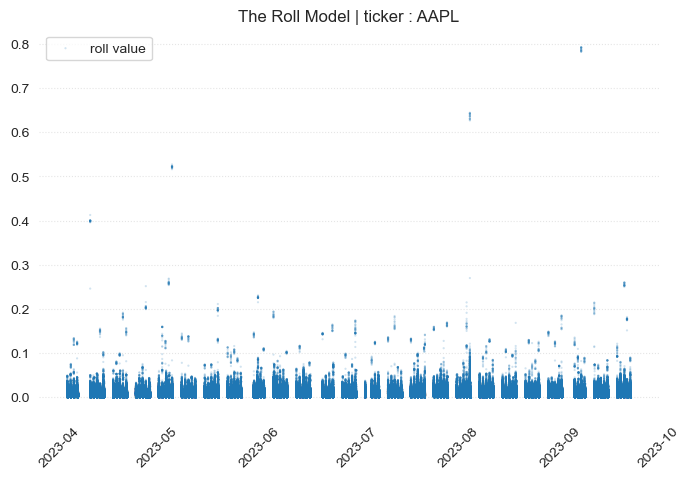

In [6]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    roll_value.index, 
    roll_value,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.2,
    s = 10,
    label = 'roll value'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('The Roll Model | ticker : AAPL')
plt.show()

### High-Low Volatility Estimator

Parkinson(1980)은 기하 브라운 운동을 따르는 연속적으로 관측되는 가격에 대해 다음을 유도했다

$$E\Big[ \frac{1}{T} \sum_{t=1}^T \Big( \log\Big[\frac{H_t}{L_t}\Big]\Big)\Big] = k_1\sigma_{HL}^2$$
$$E\Big[ \frac{1}{T} \sum_{t=1}^T \Big( \log\Big[\frac{H_t}{L_t}\Big]\Big)\Big] = k_2\sigma_{HL}$$

여기서 $k_1 = 4\log(2), k_1 = \sqrt{\frac{8}{\pi}}$, $H_t$는 바 t에 대한 고가이고, $L_t$는 바 t에 대한 저가이다. 그러면 변동성 특성 $\sigma_{HL}$은 관측된 고가-저가에 기초해 안정적으로 계산 가능하다

In [7]:
data_ohlc = data['Price'].resample('1T').ohlc()

In [8]:
data_ohlc['volume'] = data['Volume'].resample('1T').sum()

In [9]:
data_ohlc.head()

,open,high,low,close,volume
2023-04-03 09:30:00,164.27,164.90,164.25,164.770,44082
2023-04-03 09:31:00,164.79,164.90,164.73,164.765,7503
2023-04-03 09:32:00,164.84,164.84,164.66,164.660,3380
2023-04-03 09:33:00,164.64,164.98,164.61,164.980,6954
2023-04-03 09:34:00,164.99,165.55,164.98,165.490,31658


In [10]:
vol = becker_parkinson_vol(high = data_ohlc['high'], low = data_ohlc['low'])

In [11]:
vol.dropna().head()

2023-04-03 09:50:00    0.000000
2023-04-03 09:51:00    0.000000
2023-04-03 09:52:00    0.000000
2023-04-03 09:53:00    0.001210
2023-04-03 09:54:00    0.003081
dtype: float64

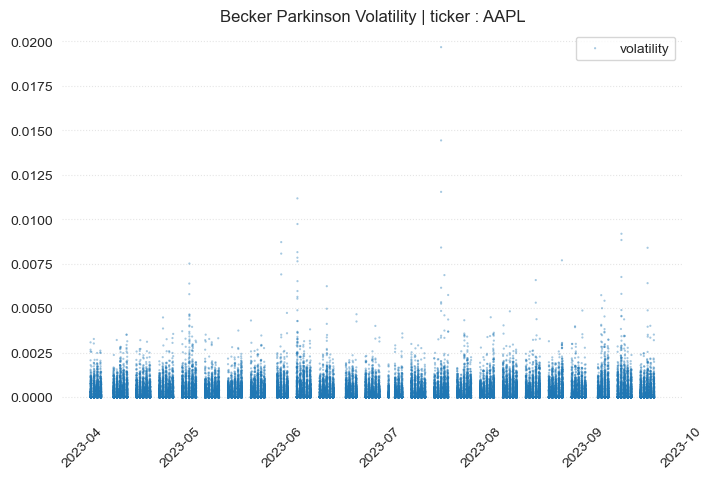

In [12]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    vol.index, 
    vol,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.4,
    s = 10,
    label = 'volatility'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Becker Parkinson Volatility | ticker : AAPL')
plt.show()

### Corwin and Schultz

Corwin, Schultz는 Beckers의 연구를 기반으로 고가와 저가로부터 매매 호가 스프레드 추정량을 소개했다. 그 추정량은 두 가지 원칙에 기반을 두고 있다. 첫째, 고가는 거의 항상 매도 호가에 매치되고, 저가는 매수 호가에 매치된다는 것이다. 고가 대비 저가의 비율은 근본적인 변동성과 bid-ask spread를 반영한다. 둘째, 변동성에 기인한 bid-ask 비율의 구성 요소는 두 관측값 사이에 경과한 시간에 비례해 증가한다.

Corwin, Schultz는 매매 호가 스프레드를 가격의 퍼센티지로 다음과 같이 계산할 수 있다는 것을 보였다.

$$S_t = \frac{2(e^{\alpha_t}-1)}{1+e^{\alpha_t}}$$

여기서

$$\alpha_t = \frac{\sqrt{2\beta_t} - \sqrt{\beta_t}}{3 - 2\sqrt{2}} - \sqrt{\frac{\gamma_t}{3-2\sqrt{2}}}$$
$$\beta_t = E \Big[\sum_{j=0}^1 \Big[\log \Big(\frac{H_{t-j}}{L_{t-j}} \Big) \Big]^2\Big]$$
$$\gamma_t = \Big[\log \Big(\frac{H_{t-1, t}}{L_{t-1, t}}\Big) \Big]^2$$

$H_{t-1,t}$는 두 기간에 걸친 고가이고, $L_{t-1,t}$는 두 기간에 걸친 저가이다. Corwin-Schultz의 식에서는 변동성이 보이지 않는데, 이는 고가/저가 추정량으로 대체되었기 때문이다. 이 모델로써 벡커-파킨슨 변동성을 유도할 수 있다. 이 스프레드 추정량은 중앙 집중된 주문 호가창이 없고, 거래가 경쟁 희망 매수 호가(Bids Wanted In Competition)에 의해 일어나는 회사채 시장에서 특히 유용하다. 그 결과 특성인 bid-ask spread는 moving average window에 걸쳐 반복적으로 계산한 후 Kalman Filter를 이용해 평활화할 수 있다.

In [13]:
spread = corwin_schultz_estimator(high = data_ohlc['high'], low = data_ohlc['low'])

In [14]:
spread.dropna().head()

2023-04-03 09:50:00    0.002139
2023-04-03 09:51:00    0.002831
2023-04-03 09:52:00    0.002704
2023-04-03 09:53:00    0.000000
2023-04-03 09:54:00    0.000000
Name: Spread, dtype: float64

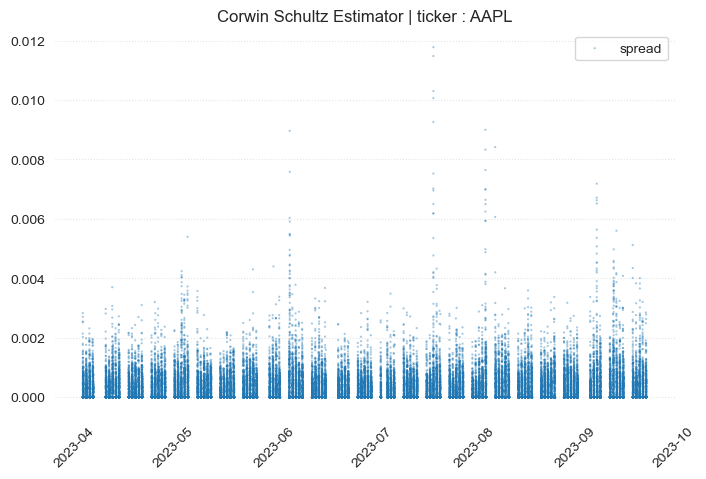

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    spread.index, 
    spread,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.4,
    s = 10,
    label = 'spread'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Corwin Schultz Estimator | ticker : AAPL')
plt.show()